In [97]:
import pandas as pd
import anndata as ad
from loguru import logger 
import time

import numpy as np
import tifffile

import matplotlib.pyplot as plt
import seaborn as sns

import shapely
import geopandas as gpd

import os
import sys
sys.path.append(os.path.abspath('../scripts'))
import utils
import importlib

import scimap as sm

In [98]:
sample_id = 994

In [99]:
path_to_quant = f"../data/quantification/{sample_id}_backsub_quantification.csv"
path_to_geojson = f"../data/geojsons/{sample_id}.geojson"
path_to_gates = "../data/phenotyping/20240918_gates.csv"

In [100]:
adata = utils.read_quant(path_to_quant)
adata

2024-09-18 17:05:47.897 | INFO     | utils:read_quant:21 -  ---- read_quant : version number 1.0.0 ----
/opt/homebrew/Caskroom/mambaforge/base/envs/scimap/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning:

Transforming to str index.

2024-09-18 17:05:52.962 | INFO     | utils:read_quant:40 -  941613 cells and 75 variables
2024-09-18 17:05:52.967 | INFO     | utils:read_quant:41 -  ---- read_quant is done, took 5s  ----


AnnData object with n_obs × n_vars = 941613 × 75
    obs: 'CellID', 'Y_centroid', 'X_centroid', 'Area', 'MajorAxisLength', 'MinorAxisLength', 'Eccentricity', 'Orientation', 'Extent', 'Solidity'
    var: 'math', 'marker'

2024-09-18 17:05:53.003 | INFO     | utils:filter_by_annotation:158 -  ---- filter_by_annotation : version number 1.2.0 ----
2024-09-18 17:05:53.017 | INFO     | utils:filter_by_annotation:164 - GeoJson loaded, detected: 8 annotations


2024-09-18 17:06:42.137 | INFO     | utils:filter_by_annotation:176 - Labelled cells with annotations if they were found inside


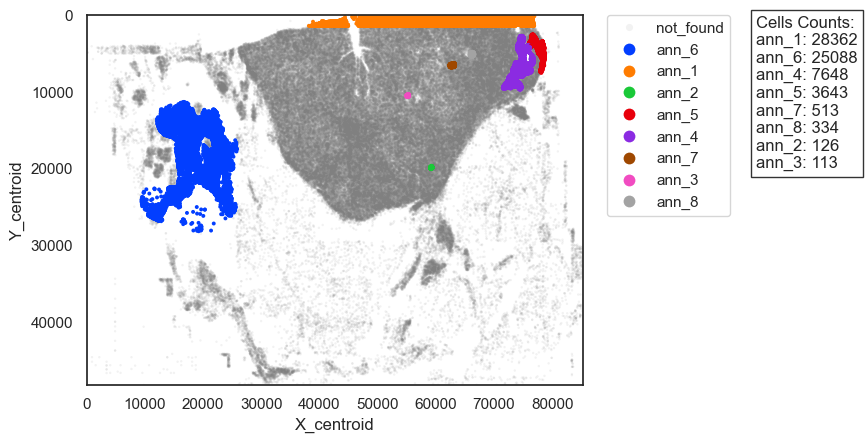

2024-09-18 17:06:43.325 | INFO     | utils:filter_by_annotation:208 -  ---- filter_by_annotation is done, took 50s  ----


In [101]:
adata = utils.filter_by_annotation(adata, path_to_geojson=path_to_geojson)

/opt/homebrew/Caskroom/mambaforge/base/envs/scimap/lib/python3.10/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning:

divide by zero encountered in log10



Threshold for DAPI intensity: 199.53
Threshold for DAPI intensity: 2818.38


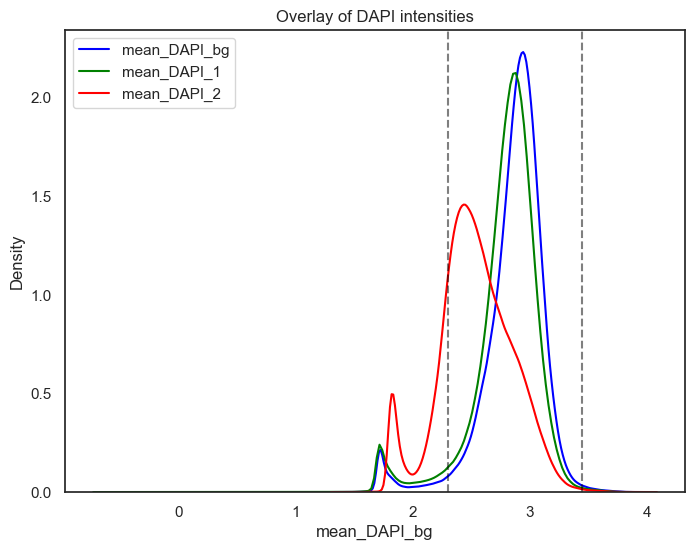

In [102]:
# Plot the density plot for each column
plt.figure(figsize=(8,6))
tmp_df = np.log10(pd.DataFrame(adata.X, columns=adata.var_names))
sns.kdeplot(tmp_df['mean_DAPI_bg'], label='mean_DAPI_bg', color='blue')
sns.kdeplot(tmp_df['mean_DAPI_1'], label='mean_DAPI_1', color='green')
sns.kdeplot(tmp_df['mean_DAPI_2'], label='mean_DAPI_2', color='red')

low_threshold = 2.3
plt.axvline(low_threshold, color='black', linestyle='--', alpha=0.5)
print(f"Threshold for DAPI intensity: {10**low_threshold:.2f}")

high_threshold = 3.45
plt.axvline(high_threshold, color='black', linestyle='--', alpha=0.5)
print(f"Threshold for DAPI intensity: {10**high_threshold:.2f}")

plt.title('Overlay of DAPI intensities')
plt.legend()
plt.show()

2024-09-18 17:06:47.135 | INFO     | utils:filter_by_abs_value:214 -  ---- filter_by_abs_value : version number 1.0.0 ----
2024-09-18 17:06:47.172 | INFO     | utils:filter_by_abs_value:230 - Number of cells with mean_DAPI_bg above 199: 903903


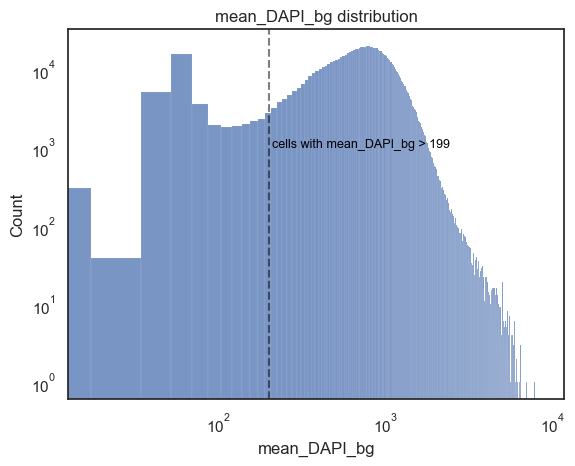

2024-09-18 17:06:47.899 | INFO     | utils:filter_by_abs_value:252 -  ---- filter_by_abs_value is done, took 0s  ----
2024-09-18 17:06:47.899 | INFO     | utils:filter_by_abs_value:214 -  ---- filter_by_abs_value : version number 1.0.0 ----
2024-09-18 17:06:47.934 | INFO     | utils:filter_by_abs_value:235 - Number of cells with mean_DAPI_bg below 2818: 937658


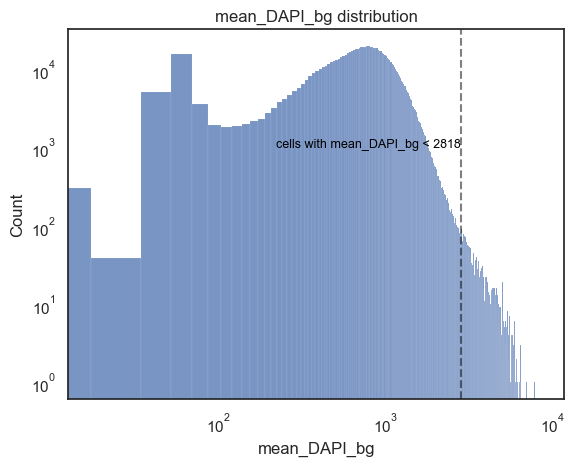

2024-09-18 17:06:48.634 | INFO     | utils:filter_by_abs_value:252 -  ---- filter_by_abs_value is done, took 0s  ----


In [103]:
adata = utils.filter_by_abs_value(adata=adata, marker="mean_DAPI_bg", value=199, direction="above")
adata = utils.filter_by_abs_value(adata=adata, marker="mean_DAPI_bg", value=2818, direction="below")

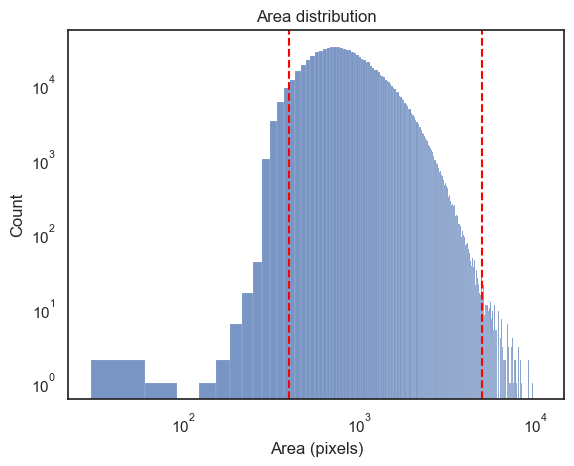

In [104]:
sns.histplot(adata.obs['Area'], bins=350)
plt.yscale('log')
plt.xscale('log')
plt.title('Area distribution')
plt.xlabel('Area (pixels)')
plt.axvline(400, color='red', linestyle='--')
plt.axvline(5000, color='red', linestyle='--')
plt.show()

In [105]:
adata.obs['Area_filter_nottoobig'] = adata.obs['Area'] < 5000
adata.obs['Area_filter_nottoolow'] = adata.obs['Area'] > 400
adata.obs['Area_filter'] = adata.obs['Area_filter_nottoobig'] & adata.obs['Area_filter_nottoolow']

#print stats
print("Number of cells before filtering: ", adata.shape[0])
print("Number of cells filtered out by Area: ", adata.shape[0] - adata.obs['Area_filter'].sum())
print("Percentage of cells filtered out by Area: ", round((adata.shape[0] - adata.obs['Area_filter'].sum())/adata.shape[0]*100, 3), "%")

Number of cells before filtering:  941613
Number of cells filtered out by Area:  17877
Percentage of cells filtered out by Area:  1.899 %


In [106]:
adata = utils.filter_by_ratio(
    adata=adata, 
    end_cycle="mean_DAPI_2", 
    start_cycle="mean_DAPI_bg", 
    label="DAPI",
    min_ratio=0.20,
    max_ratio=1.10,
    )

2024-09-18 17:06:49.372 | INFO     | utils:filter_by_ratio:111 -  ---- filter_by_ratio : version number 1.1.0 ----
2024-09-18 17:06:49.434 | INFO     | utils:filter_by_ratio:129 - Number of cells with DAPI ratio < 0.2: 35924
2024-09-18 17:06:49.469 | INFO     | utils:filter_by_ratio:130 - Number of cells with DAPI ratio > 1.1: 59178
2024-09-18 17:06:49.504 | INFO     | utils:filter_by_ratio:131 - Number of cells with DAPI ratio between 0.2 and 1.1: 846211
2024-09-18 17:06:49.539 | INFO     | utils:filter_by_ratio:132 - Percentage of cells filtered out: 10.13%


2024-09-18 17:06:53.101 | INFO     | utils:filter_by_ratio:152 -  ---- filter_by_ratio is done, took 3s  ----


In [107]:
adata = adata[adata.obs['filter_by_ann'].astype(bool) & adata.obs['mean_DAPI_bg_abs_below_value'] & adata.obs['mean_DAPI_bg_abs_above_value'] & adata.obs['Area_filter'] & adata.obs['DAPI_ratio_pass']]

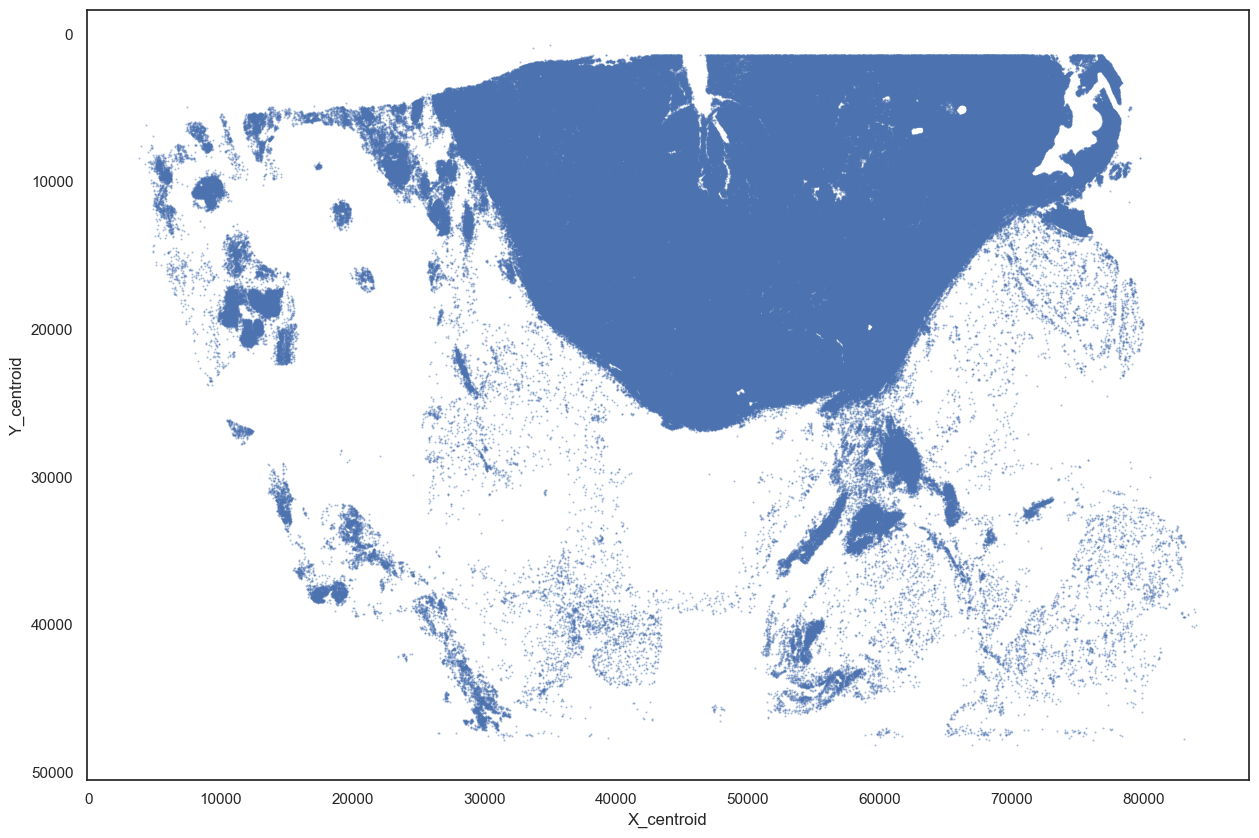

In [108]:
sns.scatterplot(data=adata.obs, x='X_centroid', y='Y_centroid', linewidth=0, s=2, alpha=0.5)
fig = plt.gcf()
fig.set_size_inches(15, 10)
plt.gca().invert_yaxis()
plt.show()

In [109]:
gates = utils.read_gates(path_to_gates)
gates = gates[gates['sample_id']==sample_id]
adata.obs['imageid'] = str(sample_id)
processed_gates = utils.process_gates_for_sm(gates, sample_id=str(sample_id))

2024-09-18 17:06:54.256 | INFO     | utils:read_gates:48 -  ---- read_gates : version number 1.0.0 ----
2024-09-18 17:06:54.263 | INFO     | utils:read_gates:53 -    Filtering out all rows with value 0.0 (assuming not gated)
2024-09-18 17:06:54.267 | INFO     | utils:read_gates:56 -   Found 79 valid gates
2024-09-18 17:06:54.268 | INFO     | utils:read_gates:58 -  ---- read_gates is done, took 0s  ----
/var/folders/x7/grkjlk8s223dy6234rnz1885mxz2_6/T/ipykernel_69205/2216073073.py:3: ImplicitModificationWarning:

Trying to modify attribute `.obs` of view, initializing view as actual.

2024-09-18 17:06:54.580 | INFO     | utils:process_gates_for_sm:77 -  ---- process_gates_for_sm : version number 1.0.0 ----
/Users/jnimoca/Jose_BI/P26_DA/scripts/utils.py:82: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

2

In [110]:
processed_gates

marker       994
470  mean_Vimentin  4.951897
471      mean_CD3e  5.541186
472     mean_panCK  4.132957
473       mean_CD8  6.159229
475    mean_COL1A1  5.707110
476      mean_CD20  6.104546
477      mean_CD68  5.317900
478      mean_Ki67  5.186424

In [111]:
adata = adata[:, processed_gates['marker']]

In [112]:
adata.raw = adata
adata = sm.pp.log1p(adata)
adata = sm.pp.rescale(adata, gate=processed_gates, log=True, verbose=True)

/opt/homebrew/Caskroom/mambaforge/base/envs/scimap/lib/python3.10/site-packages/scimap/preprocessing/rescale.py:105: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



Scaling Image 994
Scaling mean_Vimentin
Scaling mean_CD3e
Scaling mean_panCK
Scaling mean_CD8
Scaling mean_COL1A1
Scaling mean_CD20
Scaling mean_CD68
Scaling mean_Ki67


In [113]:
path_to_phenotype_matrix = "../data/phenotyping/20240905_PhenotypeMatrix_v3.csv"
phenotype_matrix = pd.read_csv(path_to_phenotype_matrix)
adata = sm.tl.phenotype_cells (adata, phenotype=phenotype_matrix, label="phenotype")

Phenotyping Cancer_cells
Phenotyping T_cells
Phenotyping Vimentin_cells
Phenotyping COL1A1_cells
Phenotyping B_cells
Phenotyping Macrophages
-- Subsetting T_cells
Phenotyping CD4_Tcells
Phenotyping CD8_Tcells
Consolidating the phenotypes across all groups


/opt/homebrew/Caskroom/mambaforge/base/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:290: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

/opt/homebrew/Caskroom/mambaforge/base/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:290: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



In [114]:
custom_colours = {
    "Cancer_cells" : "red",
    "CD4_Tcells" : "peru",
    "CD8_Tcells" : "lawngreen",
    "Macrophages" : "yellow",
    "COL1A1_cells" : "deepskyblue",
    "Vimentin_cells" : "orange",
    "B_cells" : "black",
    "Unknown" : "whitesmoke"
}

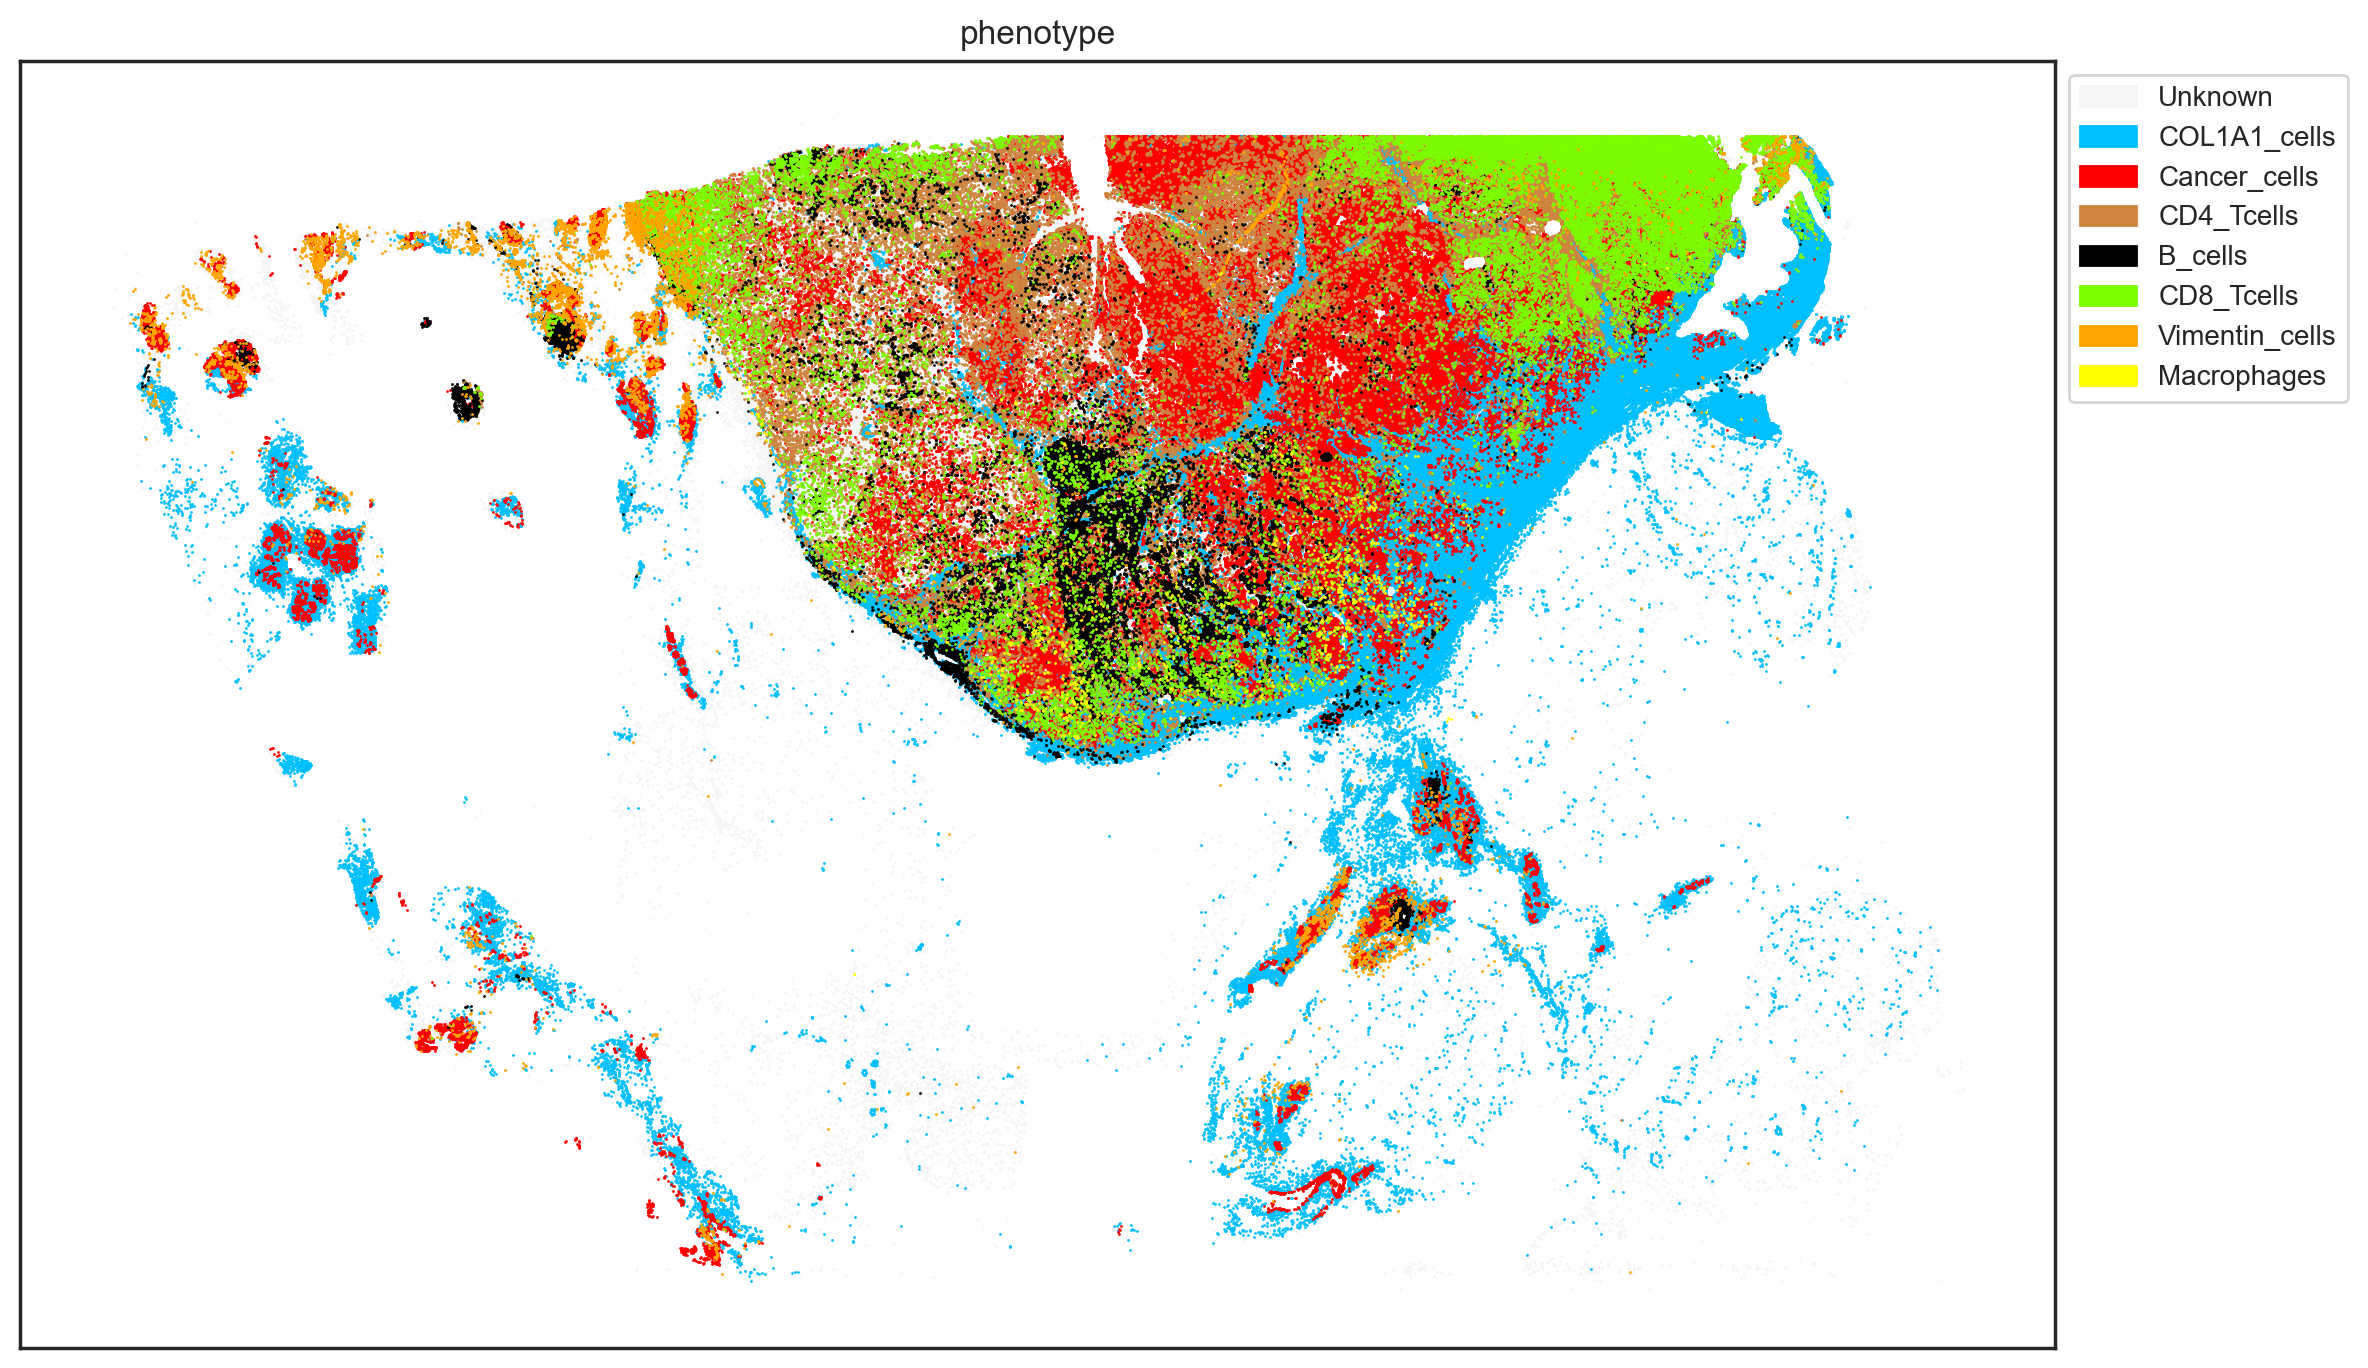

In [115]:
sm.pl.spatial_scatterPlot (adata, colorBy = ['phenotype'],figsize=(12,7), s=1, fontsize=10, customColors=custom_colours)

# Side-quest: Remove COL1A1 artefact using QuPath annotation

2024-09-18 17:07:14.086 | INFO     | utils:filter_by_annotation:158 -  ---- filter_by_annotation : version number 1.2.0 ----
2024-09-18 17:07:14.128 | INFO     | utils:filter_by_annotation:164 - GeoJson loaded, detected: 9 annotations
2024-09-18 17:07:59.798 | INFO     | utils:filter_by_annotation:176 - Labelled cells with annotations if they were found inside


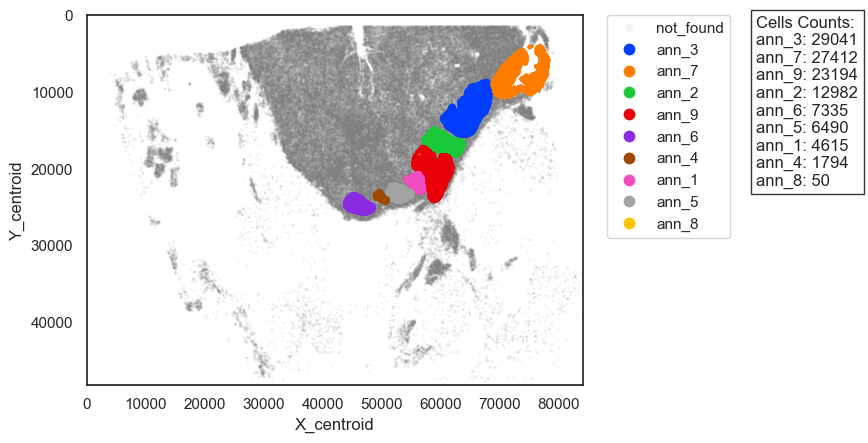

2024-09-18 17:08:01.020 | INFO     | utils:filter_by_annotation:208 -  ---- filter_by_annotation is done, took 46s  ----


In [116]:
path_to_COL1A1_geojson = "../data/geojsons/994_COL1A1.geojson"
adata = utils.filter_by_annotation(adata=adata, path_to_geojson=path_to_COL1A1_geojson, column_name="COL1A1_art_free")

In [132]:
array = adata[:,'mean_COL1A1'].X.toarray()

print( f" how many zeroes: {np.count_nonzero(array==0)}")
print( f"array shape {array.shape}")
print( f"array mean {array.mean()}")
print( f"data type {type(array)}")

 how many zeroes: 112914
array shape (789981, 1)
array mean 0.4054599495603902
data type <class 'numpy.ndarray'>


In [123]:
# change values according to COL1A1_art_free
array[~adata.obs['COL1A1_art_free'].values] = 0

In [131]:
#count how many 0s are in the array
print( f" how many zeroes: {np.count_nonzero(array==0)}")
print( f"array shape {array.shape}")
print( f"array mean {array.mean()}")

 how many zeroes: 112914
array shape (789981, 1)
array mean 0.4054599495603902


In [129]:
adata[:,'mean_COL1A1'].X = array

In [81]:
adata[:, adata.var_names.str.contains("mean_COL1A1")].X = new_COL1A1_array

/opt/homebrew/Caskroom/mambaforge/base/envs/scimap/lib/python3.10/site-packages/anndata/_core/anndata.py:618: FutureWarning:

You are attempting to set `X` to a matrix on a view which has non-unique indices. The resulting `adata.X` will likely not equal the value to which you set it. To avoid this potential issue, please make a copy of the data first. In the future, this operation will throw an error.



In [84]:
adata.X.shape

(789981, 75)

In [86]:
adata.X[:, adata.var_names.str.contains("mean_COL1A1")].mean()

87.66700187199156

In [93]:
# ok we proceed
gates = utils.read_gates("/Volumes/RD_Coscia/Jose/P26_BCCN/P26E12_Gates/gates/20240911_gates.csv")
gates = gates[gates['sample_id']==sample_id]

2024-09-18 16:03:28.252 | INFO     | utils:read_gates:48 -  ---- read_gates : version number 1.0.0 ----
2024-09-18 16:03:28.261 | INFO     | utils:read_gates:53 -    Filtering out all rows with value 0.0 (assuming not gated)
2024-09-18 16:03:28.262 | INFO     | utils:read_gates:56 -   Found 79 valid gates
2024-09-18 16:03:28.262 | INFO     | utils:read_gates:58 -  ---- read_gates is done, took 0s  ----


In [133]:
adata = sm.tl.phenotype_cells (adata, phenotype=phenotype_matrix, label="phenotype_v2")

Phenotyping Cancer_cells
Phenotyping T_cells
Phenotyping Vimentin_cells
Phenotyping COL1A1_cells
Phenotyping B_cells
Phenotyping Macrophages
-- Subsetting T_cells
Phenotyping CD4_Tcells
Phenotyping CD8_Tcells
Consolidating the phenotypes across all groups


/opt/homebrew/Caskroom/mambaforge/base/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:290: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

/opt/homebrew/Caskroom/mambaforge/base/envs/scimap/lib/python3.10/site-packages/scimap/tools/phenotype_cells.py:290: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



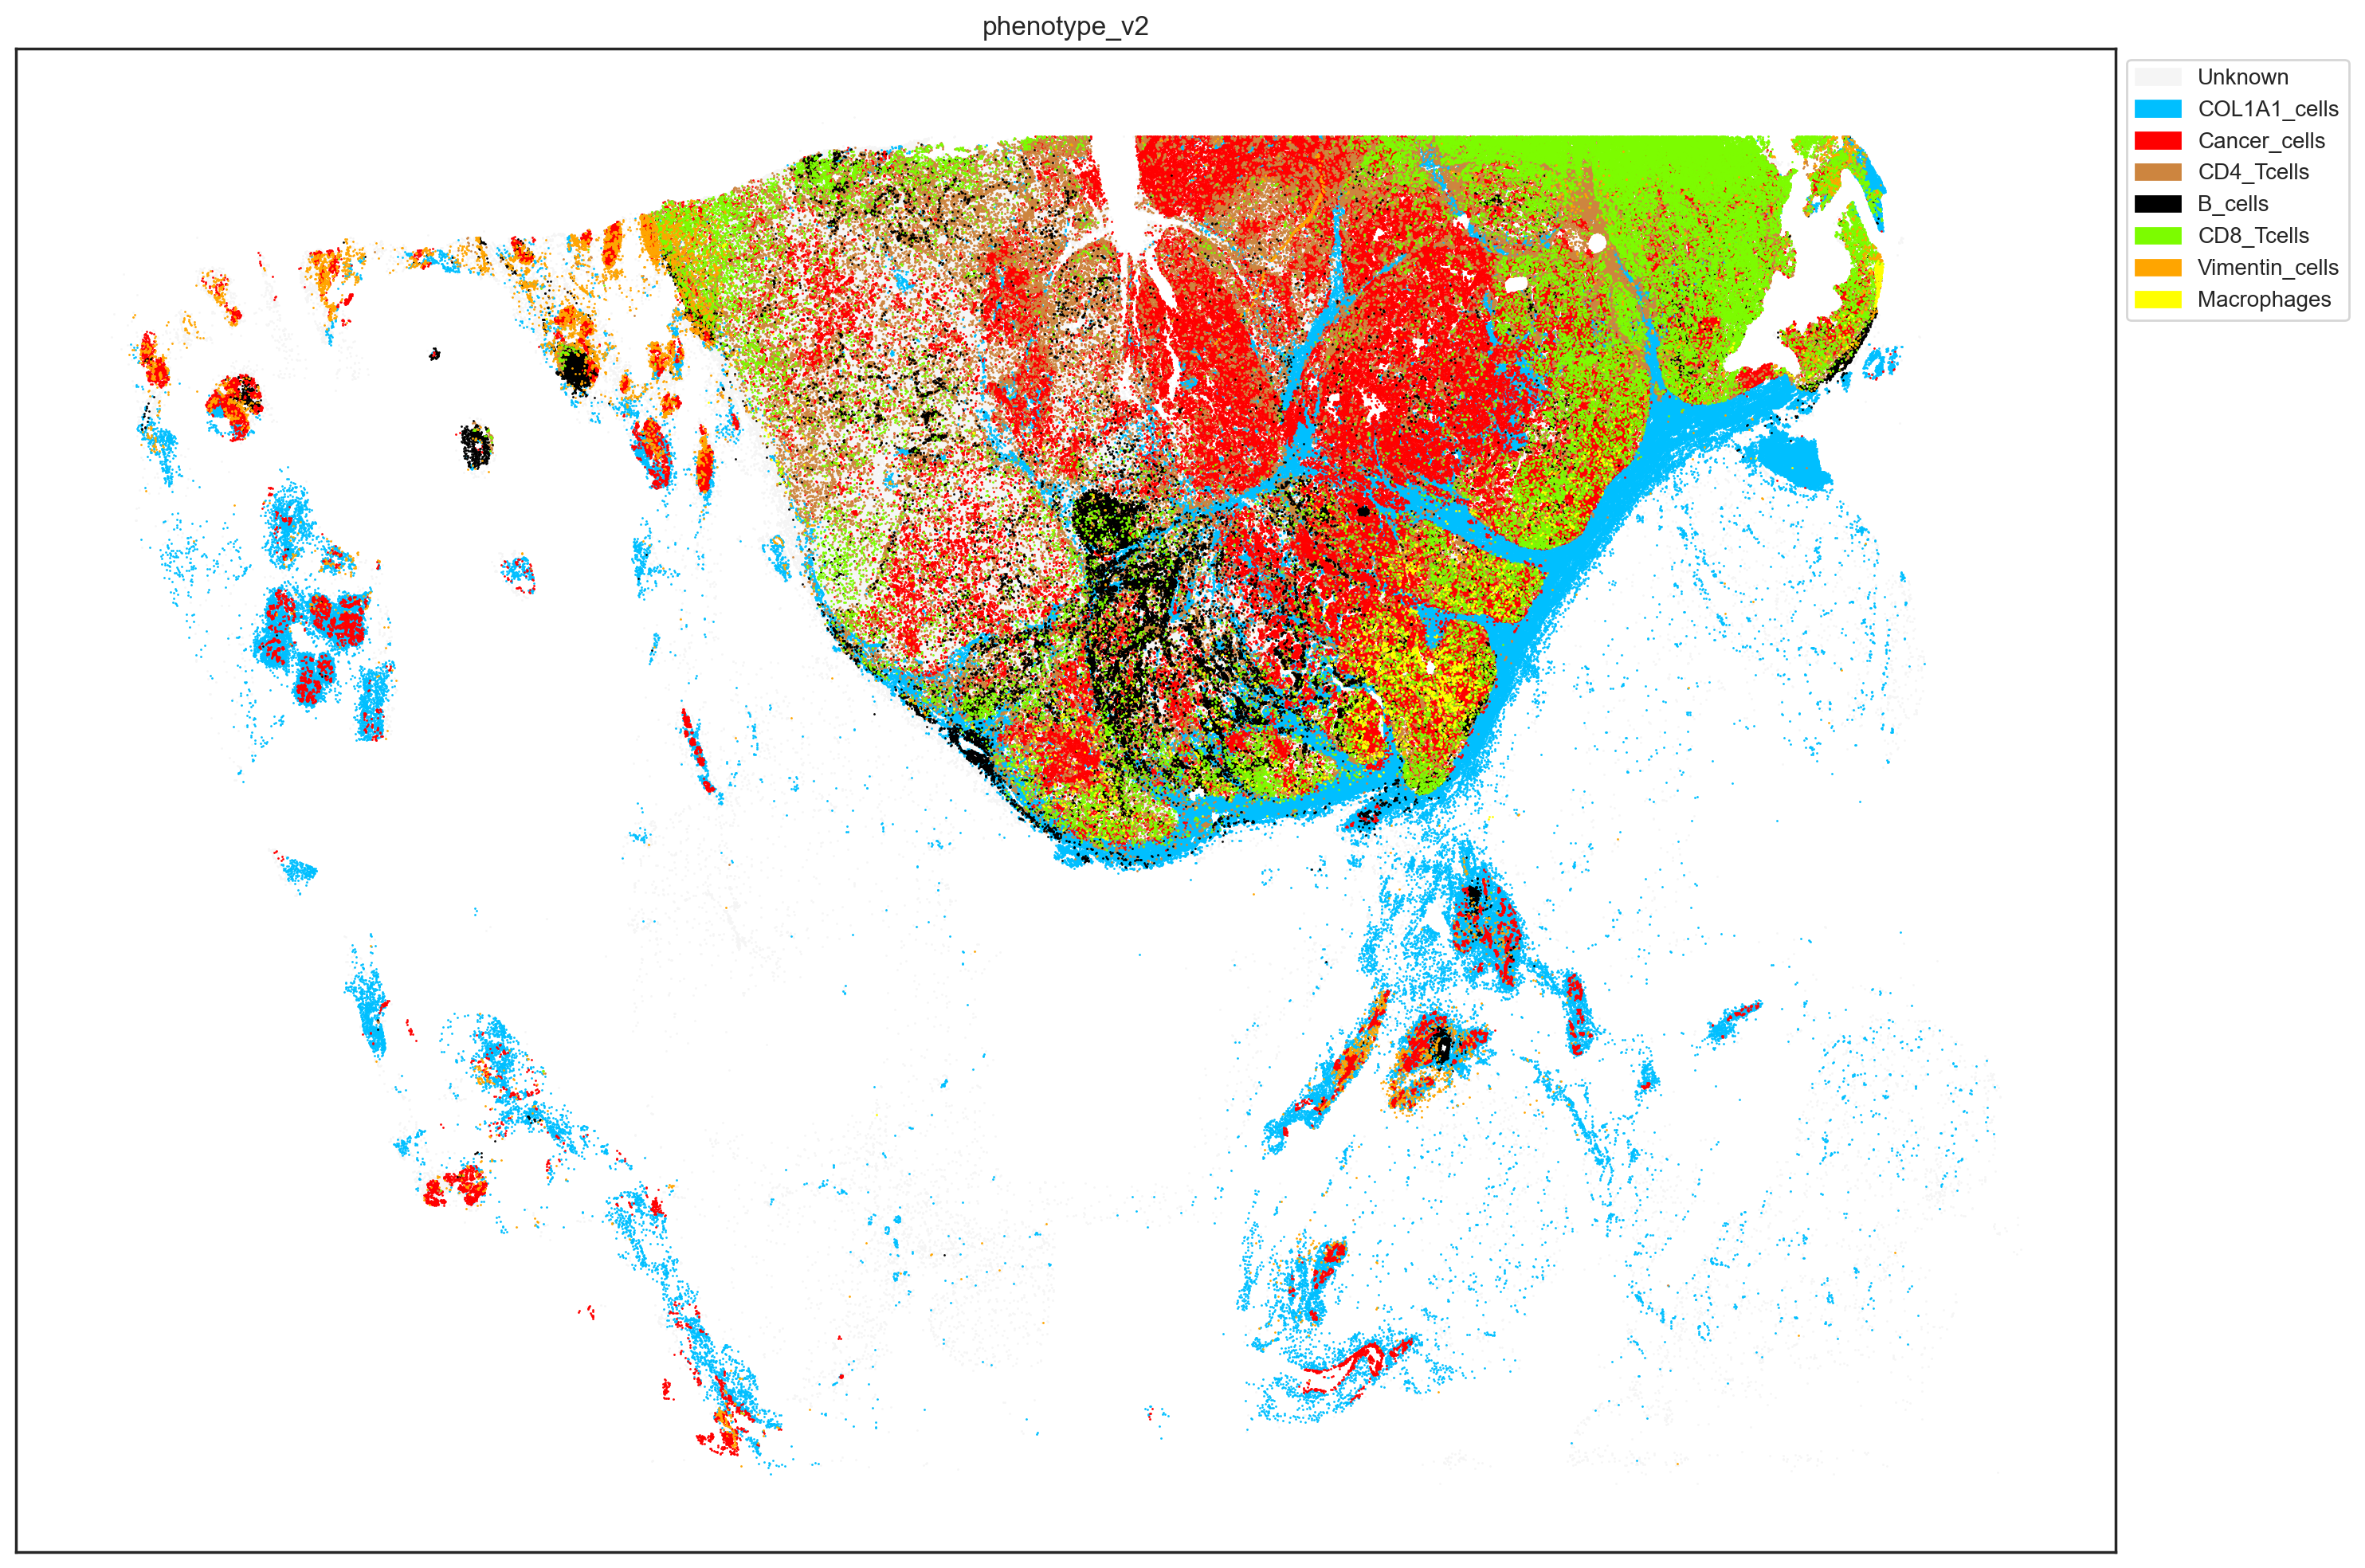

In [138]:
sm.pl.spatial_scatterPlot (adata, colorBy = ['phenotype_v2'],figsize=(15,10), s=1, fontsize=10, customColors=custom_colours)